# NeuralProphet Modeling

NeuralProphet is a Neural Network based user-friendly time series forecasting tool. This is heavily inspired by Prophet, which is the popular forecasting tool developed by Facebook. NeuralProphet is developed in a fully modular architecture which makes it scalable to add any additional components in the future.
NeuralProphet is a decomposable time series model with the components, trend, seasonality, auto-regression, special events, future regressors and lagged regressors. Auto-regression is handled using an implementation of AR-Net, an Auto-Regressive Feed-Forward Neural Network for time series.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from neuralprophet import NeuralProphet, set_random_seed 
set_random_seed(42)
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
%matplotlib inline
np.random.seed(42)

In [2]:
df_o = pd.read_csv("./data/cleaned_data.csv").drop('Unnamed: 0', axis=1)

In [3]:
df_o['business_date'] = pd.to_datetime(df_o['business_date'])

In [4]:
df_o = df_o.groupby('business_date').agg('sum')

In [5]:
df_o.reset_index()

,business_date,s_rev_mkt,s_def_rooms_mkt,s_fb_rev_mkt,s_misc_rev_mkt,mkt_resort_room,guest_mkt,tot_arr_mkt,per_occ_mkt,per_double_mkt,...,in_guest,occ_single,double_occ,revenue,fb_rev,other_rev,total_revenue,per_occ,get_arr,multi_occ_per
0,2017-07-01,8070961.93,25521.0,679349.22,550182.07,296380.0,33864.0,2108.764920,60.276334,14.331601,...,97.0,13.0,37.0,11501.65,0.0,1619.41,13121.06,43.103448,452.869318,31.896552
1,2017-07-02,5440456.42,17674.0,1378791.70,260446.54,296380.0,19782.0,1741.045422,41.743033,4.364667,...,11.0,5.0,3.0,1642.78,0.0,216.00,1858.78,6.896552,434.502667,2.586207
2,2017-07-03,8062495.78,25746.0,1379291.70,528138.65,296380.0,34797.0,1781.662207,60.807747,15.715635,...,70.0,10.0,24.0,7403.02,0.0,942.47,8345.49,29.310345,660.028222,20.689655
3,2017-07-04,6788753.08,21924.0,758642.06,420381.04,338720.0,31029.0,1998.872078,51.780822,15.692017,...,48.0,8.0,16.0,5491.39,0.0,778.39,6269.78,20.689655,689.679500,13.793103
4,2017-07-05,4912994.47,15939.0,1321092.12,443387.54,296380.0,24960.0,1646.418409,37.645253,15.573925,...,63.0,12.0,22.0,8752.08,0.0,1298.00,10050.08,29.310345,257.414118,18.965517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,2020-12-27,2046627.22,6483.0,332079.09,360780.83,297192.0,7585.0,1928.656675,15.269927,2.383644,...,3.0,3.0,0.0,289.28,0.0,136.27,425.55,2.586207,96.426667,0.000000
1276,2020-12-28,1962482.94,8241.0,525562.73,569059.91,297192.0,11158.0,1703.659720,19.410684,6.175806,...,8.0,3.0,2.0,621.25,0.0,234.07,855.32,4.310345,253.465000,1.724138
1277,2020-12-29,2834322.03,10307.0,558730.93,609070.88,382104.0,13386.0,2296.414106,24.276898,6.566799,...,4.0,2.0,1.0,416.17,0.0,59.99,476.16,2.586207,263.845000,0.862069
1278,2020-12-30,2340613.63,7423.0,558730.93,440217.59,297192.0,9555.0,1913.851186,17.483983,4.583569,...,3.0,1.0,1.0,249.65,0.0,313.00,562.65,1.724138,124.825000,0.862069


In [6]:
df = df_o.drop(columns=[col for col in df_o.columns if col not in ['no_definite_rooms']]).reset_index()

Simialar to Prophet's functionality, the dataframe needs to have a 'ds' column with time series and a 'y' column for our predicted variable.

In [7]:
df.columns= ['ds','y']

In [8]:
df[549:914] # seperating training data out by index

,ds,y
549,2019-01-01,20.0
550,2019-01-02,43.0
551,2019-01-03,36.0
552,2019-01-04,45.0
553,2019-01-05,24.0
...,...,...
909,2019-12-27,51.0
910,2019-12-28,64.0
911,2019-12-29,49.0
912,2019-12-30,56.0


NeuralProhet's interface allows to choose seasonality, normalization function, pre-built holidays, validation scenarios and many other hyperparameters that are still in experimental state, so users have to be careful utilizing them. In the making of this model, lot's of different scenarios were explored and it was obvious that this package is still in its development stage.

In [9]:
m = NeuralProphet(loss_func='MSE', weekly_seasonality=True)
m.add_country_holidays(country_name='US', mode="additive", lower_window=-1, upper_window=1)
df_train, df_val = df[:549], df[549:914]
metrics = m.fit(df_train, freq="D", validate_each_epoch=True, valid_p=0.2)
future = m.make_future_dataframe(df_train, periods=365)
forecast = m.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 72


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-01
Epoch[72/72]: 100%|██████████| 72/72 [00:11<00:00,  6.21it/s, MSELoss=0.0331, MAE=16.5, RegLoss=0, MAE_val=20.2, MSELoss_val=0.0449]


You can also perform validation per every epoch during model fitting. This is done as follows by setting the  validate_each_epoch argument in the fit function call. This lets you look at the validation metrics while model training.

In [10]:
forecast

,ds,y,yhat1,residual1,trend,season_weekly
0,2019-01-01,None,33.718243,None,51.984119,9.852861
1,2019-01-02,None,6.837931,None,51.961643,10.572914
2,2019-01-03,None,56.244316,None,51.939167,4.305146
3,2019-01-04,None,42.851768,None,51.916691,-9.064922
4,2019-01-05,None,42.300549,None,51.894215,-9.593666
...,...,...,...,...,...,...
360,2019-12-27,None,34.827450,None,43.892376,-9.064922
361,2019-12-28,None,34.276234,None,43.869900,-9.593666
362,2019-12-29,None,35.744892,None,43.847424,-8.102531
363,2019-12-30,None,45.855141,None,43.824944,2.030198


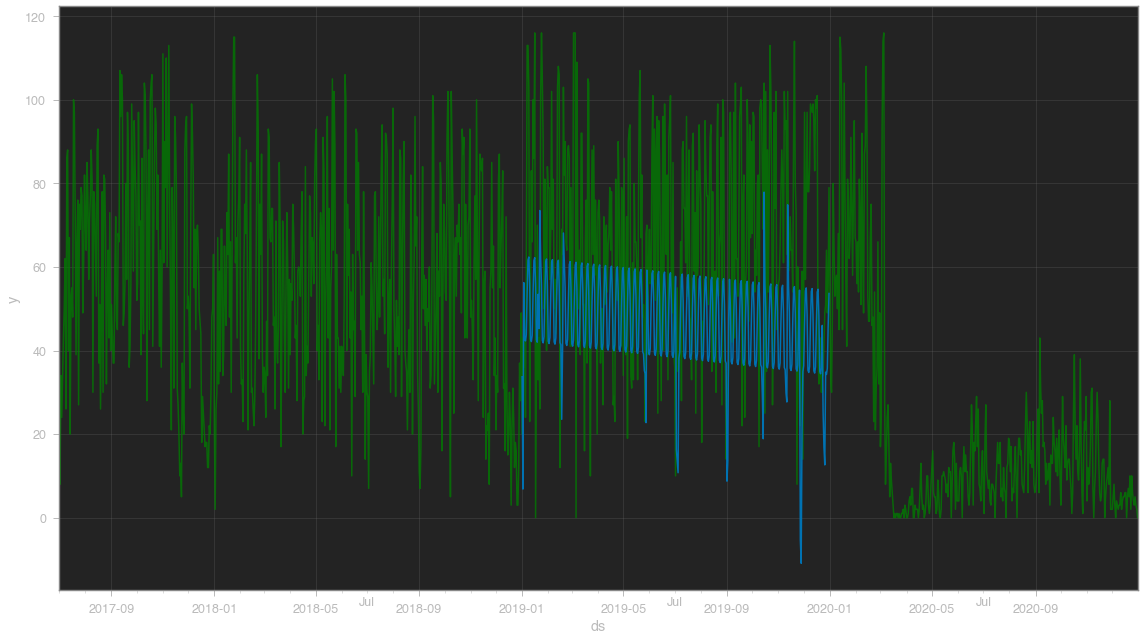

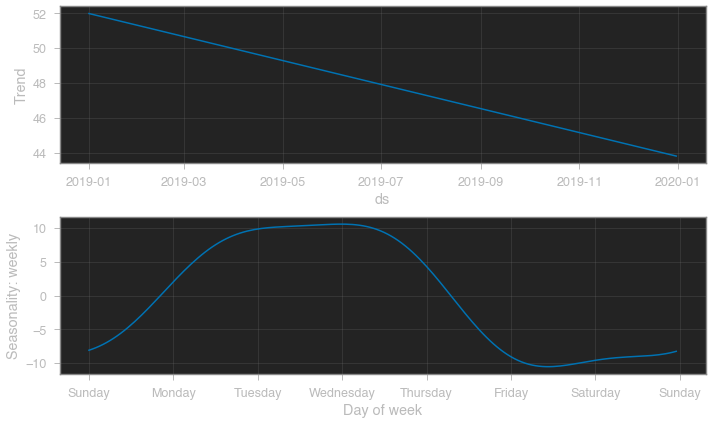

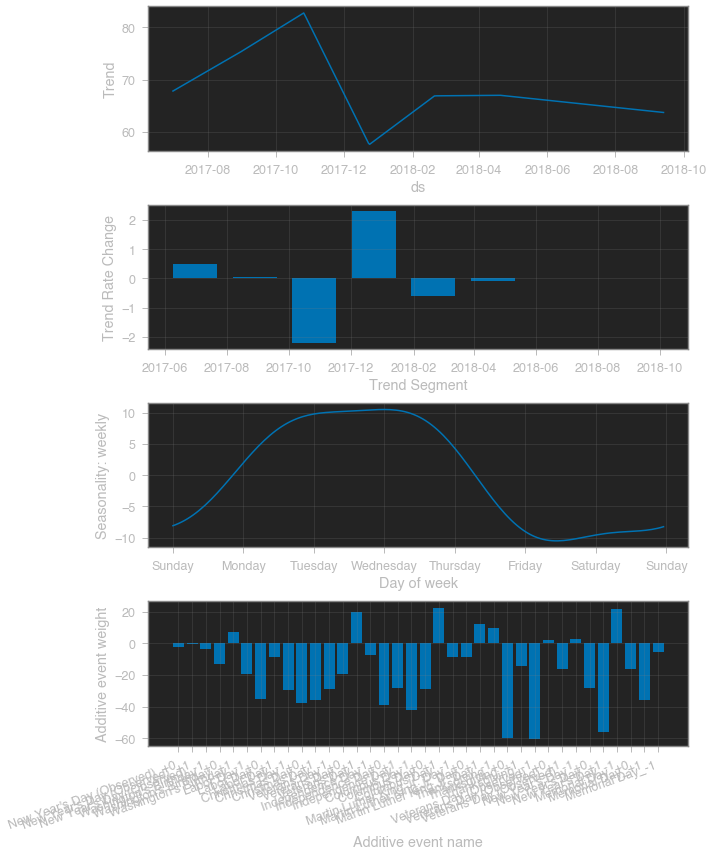

In [11]:
ax = df_o['no_definite_rooms'].plot(label='Observed', alpha=0.75, figsize=(16,9), color='green')
fig_forecast = m.plot(forecast, ax=ax)
fig_components = m.plot_components(forecast)
fig_model = m.plot_parameters()

In [12]:
val_metrics = m.test(df_val)

INFO: nprophet - _evaluate: Validation metrics:    MSELoss    MAE
1    0.079 26.939


In [13]:
train_metrics = m.test(df_train)

INFO: nprophet - _evaluate: Validation metrics:    MSELoss    MAE
1    0.035 17.259


# NeuralProphet Revenue:

In [14]:
df = pd.read_csv("./data/cleaned_data.csv").drop('Unnamed: 0', axis=1)

In [15]:
df['business_date'] = pd.to_datetime(df['business_date'])

In [16]:
df = df.groupby('business_date').agg('sum')

In [17]:
df.reset_index()

,business_date,s_rev_mkt,s_def_rooms_mkt,s_fb_rev_mkt,s_misc_rev_mkt,mkt_resort_room,guest_mkt,tot_arr_mkt,per_occ_mkt,per_double_mkt,...,in_guest,occ_single,double_occ,revenue,fb_rev,other_rev,total_revenue,per_occ,get_arr,multi_occ_per
0,2017-07-01,8070961.93,25521.0,679349.22,550182.07,296380.0,33864.0,2108.764920,60.276334,14.331601,...,97.0,13.0,37.0,11501.65,0.0,1619.41,13121.06,43.103448,452.869318,31.896552
1,2017-07-02,5440456.42,17674.0,1378791.70,260446.54,296380.0,19782.0,1741.045422,41.743033,4.364667,...,11.0,5.0,3.0,1642.78,0.0,216.00,1858.78,6.896552,434.502667,2.586207
2,2017-07-03,8062495.78,25746.0,1379291.70,528138.65,296380.0,34797.0,1781.662207,60.807747,15.715635,...,70.0,10.0,24.0,7403.02,0.0,942.47,8345.49,29.310345,660.028222,20.689655
3,2017-07-04,6788753.08,21924.0,758642.06,420381.04,338720.0,31029.0,1998.872078,51.780822,15.692017,...,48.0,8.0,16.0,5491.39,0.0,778.39,6269.78,20.689655,689.679500,13.793103
4,2017-07-05,4912994.47,15939.0,1321092.12,443387.54,296380.0,24960.0,1646.418409,37.645253,15.573925,...,63.0,12.0,22.0,8752.08,0.0,1298.00,10050.08,29.310345,257.414118,18.965517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,2020-12-27,2046627.22,6483.0,332079.09,360780.83,297192.0,7585.0,1928.656675,15.269927,2.383644,...,3.0,3.0,0.0,289.28,0.0,136.27,425.55,2.586207,96.426667,0.000000
1276,2020-12-28,1962482.94,8241.0,525562.73,569059.91,297192.0,11158.0,1703.659720,19.410684,6.175806,...,8.0,3.0,2.0,621.25,0.0,234.07,855.32,4.310345,253.465000,1.724138
1277,2020-12-29,2834322.03,10307.0,558730.93,609070.88,382104.0,13386.0,2296.414106,24.276898,6.566799,...,4.0,2.0,1.0,416.17,0.0,59.99,476.16,2.586207,263.845000,0.862069
1278,2020-12-30,2340613.63,7423.0,558730.93,440217.59,297192.0,9555.0,1913.851186,17.483983,4.583569,...,3.0,1.0,1.0,249.65,0.0,313.00,562.65,1.724138,124.825000,0.862069


In [18]:
df = df.drop(columns=[col for col in df.columns if col not in ['revenue']]).reset_index()

In [19]:
df.columns= ['ds','y']

In [30]:
m = NeuralProphet(loss_func='MSE', weekly_seasonality=True, normalize='auto')
m.add_country_holidays(country_name='US', mode="additive", lower_window=-1, upper_window=1)
df_train, df_val = df[:549], df[549:914]
metrics = m.fit(df_train, freq="D", validate_each_epoch=True, valid_p=0.2)
future = m.make_future_dataframe(df_train, periods=365)
forecast = m.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 72


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-03
Epoch[72/72]: 100%|██████████| 72/72 [00:15<00:00,  4.76it/s, MSELoss=0.0565, MAE=6.4e+3, RegLoss=0, MAE_val=8.47e+3, MSELoss_val=0.0862] 


You can also perform validation per every epoch during model fitting. This is done as follows by setting the  validate_each_epoch argument in the fit function call. This lets you look at the validation metrics while model training.

In [31]:
forecast

,ds,y,yhat1,residual1,trend,season_weekly
0,2019-01-01,None,10419.955078,None,18751.238281,5930.188965
1,2019-01-02,None,2052.901367,None,18757.312500,5301.640137
2,2019-01-03,None,19669.666016,None,18763.388672,906.279236
3,2019-01-04,None,13018.326172,None,18769.462891,-5751.136719
4,2019-01-05,None,13146.070312,None,18775.539062,-5629.467773
...,...,...,...,...,...,...
360,2019-12-27,None,15187.003906,None,20938.140625,-5751.136719
361,2019-12-28,None,15314.748047,None,20944.216797,-5629.467773
362,2019-12-29,None,18724.917969,None,20950.291016,-2225.372803
363,2019-12-30,None,22424.234375,None,20956.367188,1467.867188


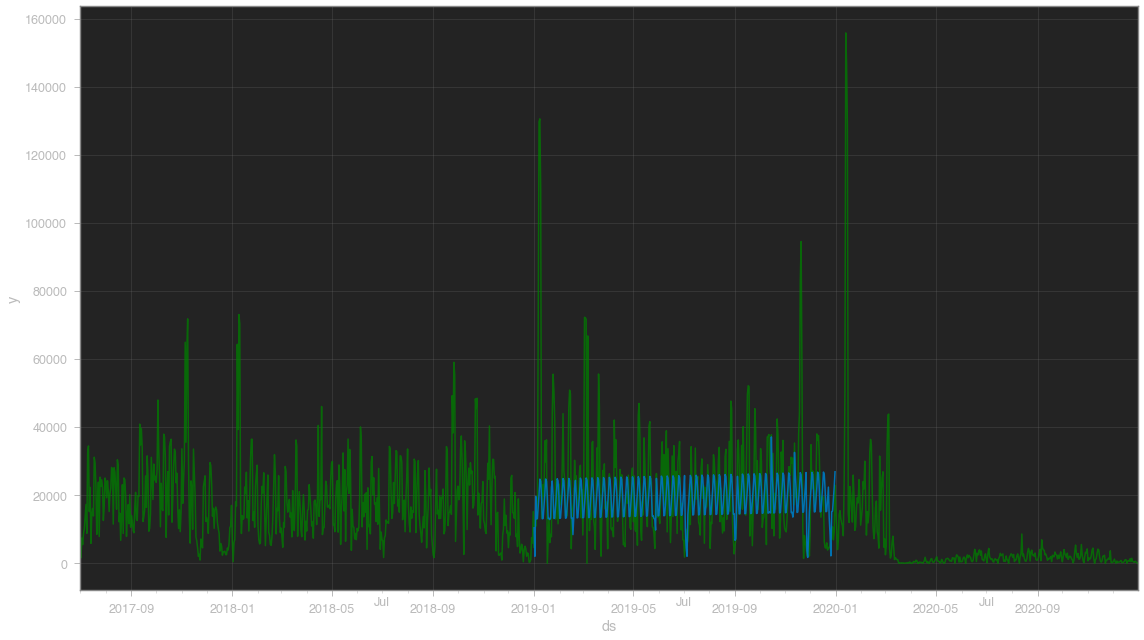

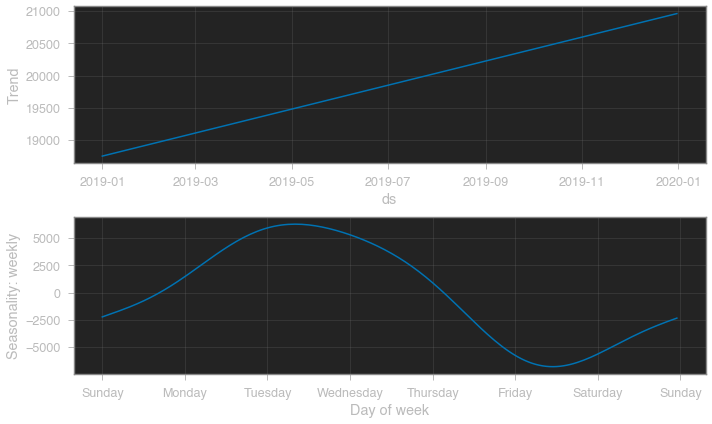

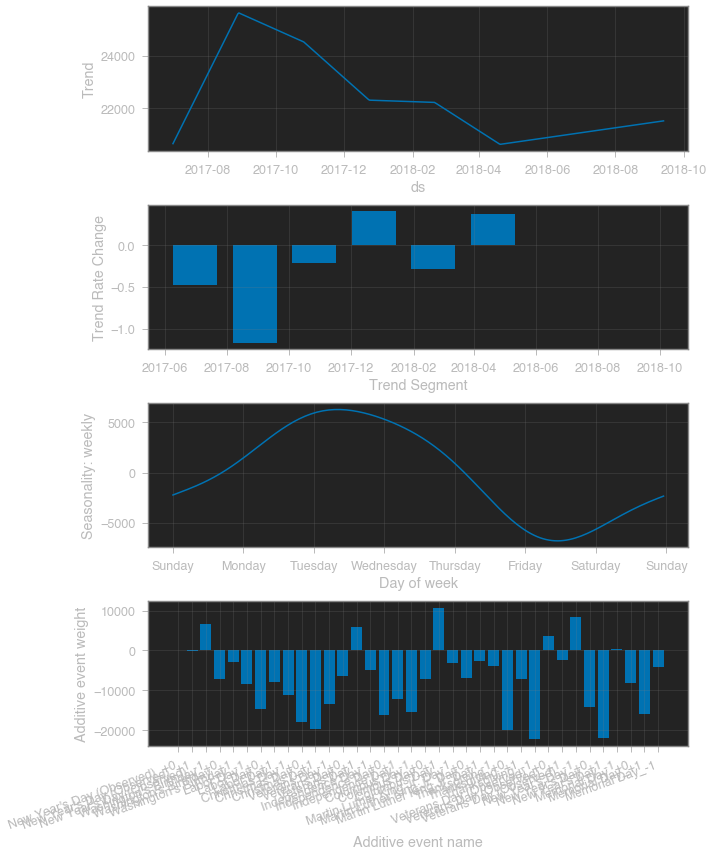

In [32]:
ax = df_o['revenue'].plot(label='Observed', alpha=0.75, figsize=(16,9), color='green')
fig_forecast = m.plot(forecast, ax=ax)
fig_components = m.plot_components(forecast)
fig_model = m.plot_parameters()

In [33]:
val_metrics = m.test(df_val)

INFO: nprophet - _evaluate: Validation metrics:    MSELoss      MAE
1    0.163 9554.999


In [34]:
train_metrics = m.test(df_train)

INFO: nprophet - _evaluate: Validation metrics:    MSELoss      MAE
1    0.062 6811.213


Although this is a fairly new package, it is very fast and produces impressive results out of the box. However, there are still a lot of experimental features that affect the results significantly. This model is the best performing model out of all and is recommended to be used for this project further.